# Stacked Bar Chart for the oviINr inputs
This notebook goes through the steps of creating a stacked bar chart for connectome data. It pulls the modularity data and the synaptic weight data for oviIN_r's inputs. 

1. Finds the top connections to oviINr
2. Merges the modularity and synaptic weight data on the bodyId column
3. Groups the dataframe by celltype and module id number while adding up the weights if they need to
4. Table is pivoted so that the modules are the columns
5. Totals are added up of the celltypes to sort and check results
6. Stacked bar plot shows the module id that the celltypes are sorted into

Written by Rhessa Weber Langstaff based on steps by Dr. Gabrielle J Gutierrez

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"
import bokeh.palettes
from neuprint import Client, fetch_simple_connections

# Load the authentication token 
auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:v1.2.1', token=auth_token)
except:
    np_client = None

In [2]:
# Pull in inputr data
ovi_in = pd.read_csv('oviIN_sep10/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv')

# set up color map "bright" for plotting
cmap = bokeh.palettes.tol['Bright'][ovi_in['0.0'].max()]
colormap = dict(zip(ovi_in['0.0'].sort_values().unique(), cmap))
colormap

{1: '#4477AA',
 2: '#EE6677',
 3: '#228833',
 4: '#CCBB44',
 5: '#66CCEE',
 6: '#AA3377',
 7: '#BBBBBB'}

In [3]:
# body IDs of oviINs from Neuprint
oviINr_bodyID = 423101189
oviINl_bodyID = 485934965

# inputs to oviINr and using only necessary columns
ovi_inputs = fetch_simple_connections(None,oviINr_bodyID)
ovi_inputs_f = ovi_inputs[['bodyId_pre','type_pre','weight']]  

# Find the top 20 inputs to oviINr
ovi_inputs_filter = ovi_inputs[['type_pre','weight']]  

# collapse ovi_inputs by cell type and sort in descending order
ovi_inputs_top = ovi_inputs_filter.groupby('type_pre', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

# filter out cell types with less than 100 inputs
ovi_inputs_final = ovi_inputs_top[ovi_inputs_top['weight'] >= 100]

ovi_inputs_final.head()

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290


In [4]:
# Merge weights onto ovi_in
ovi_in_merged = pd.merge(ovi_in, ovi_inputs_f, how='left', left_on='id', right_on='bodyId_pre')

# Extract the columns we need
ovi_in_merged = ovi_in_merged[['celltype','0.0','weight']]

# Collapse the table by celltype and number in 0.0, adding up the weights
ovi_in_collapsed = ovi_in_merged.groupby(['celltype','0.0'], as_index=False).sum()

# map colors onto 0.0 column
ovi_in_collapsed

,celltype,0.0,weight
0,5-HTPMPD01,3,3
1,5-HTPMPV01,4,3
2,5-HTPMPV03,4,1
3,AOTU003,7,1
4,AOTU008_a,7,1
...,...,...,...
1055,pC1d,7,140
1056,pC1e,7,148
1057,v2LN37,2,4
1058,vpoDN,3,2


In [5]:
# Pivot the table so that the columns are the number of inputs and the rows are the cell types
ovi_in_pivot = ovi_in_collapsed.pivot(index='celltype', columns='0.0', values='weight')

# Filter celltypes for those in ovi_inputs_final
ovi_in_pivot = ovi_in_pivot[ovi_in_pivot.index.isin(ovi_inputs_final['type_pre'])]

# Add total number of inputs to each cell type
ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)

# Sort by total number of inputs
ovi_in_pivot = ovi_in_pivot.sort_values(by='total', ascending=False)

# Drop total column so it doesn't get plotted
ovi_in_pivot = ovi_in_pivot.drop(columns='total')

#add row that has the colors
#ovi_in_pivot.loc['color'] = ovi_in_pivot.columns.map(colormap)

ovi_in_pivot

0.0,1,2,3,4,5,6,7
celltype,,,,,,,
FS1A,892.0,NaN,NaN,NaN,NaN,NaN,NaN
IB017,NaN,NaN,NaN,NaN,NaN,370.0,NaN
SMP052,NaN,NaN,NaN,322.0,39.0,NaN,NaN
SMP176,NaN,NaN,NaN,287.0,12.0,NaN,NaN
FC2B,290.0,NaN,NaN,NaN,NaN,NaN,NaN
SMP383,NaN,NaN,NaN,281.0,NaN,NaN,NaN
SMP544,NaN,NaN,NaN,NaN,4.0,NaN,255.0
LAL134,NaN,NaN,NaN,NaN,4.0,NaN,243.0
SMP550,NaN,NaN,147.0,NaN,87.0,NaN,NaN


This table contains the synapse counts for each celltype in the cells. The synapse counts can be in different modules which are the columns. 

In [6]:
# INdex to each column and set them to the column name
ovi_in_pivot.columns = range(0, ovi_in_pivot.shape[1])
# fill in NaN values with 0
ovi_in_pivot = ovi_in_pivot.fillna(0)
ovi_in_pivot.reset_index()


,celltype,0,1,2,3,4,5,6
0,FS1A,892.0,0.0,0.0,0.0,0.0,0.0,0.0
1,IB017,0.0,0.0,0.0,0.0,0.0,370.0,0.0
2,SMP052,0.0,0.0,0.0,322.0,39.0,0.0,0.0
3,SMP176,0.0,0.0,0.0,287.0,12.0,0.0,0.0
4,FC2B,290.0,0.0,0.0,0.0,0.0,0.0,0.0
5,SMP383,0.0,0.0,0.0,281.0,0.0,0.0,0.0
6,SMP544,0.0,0.0,0.0,0.0,4.0,0.0,255.0
7,LAL134,0.0,0.0,0.0,0.0,4.0,0.0,243.0
8,SMP550,0.0,0.0,147.0,0.0,87.0,0.0,0.0
9,CRE075,0.0,0.0,0.0,0.0,0.0,225.0,0.0


In [8]:
module1 = ovi_in_pivot[0]
module2 = ovi_in_pivot[1]
module3 = ovi_in_pivot[2]
module4 = ovi_in_pivot[3]
module5 = ovi_in_pivot[4]
module6 = ovi_in_pivot[5]
module7 = ovi_in_pivot[6]


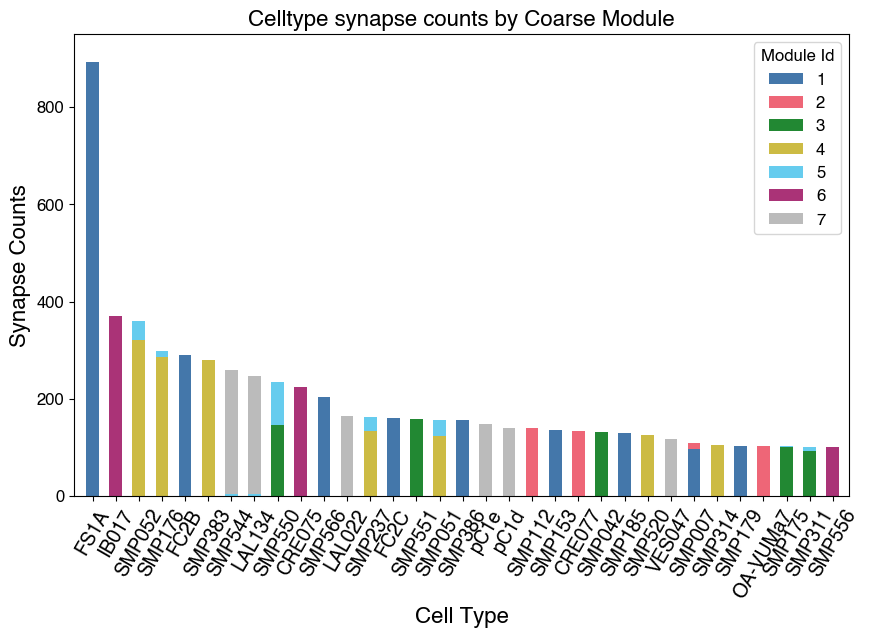

In [12]:
# Plot the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))  
ax.bar(ovi_in_pivot.index, ovi_in_pivot[0], label='1', color=colormap[1], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[1], bottom=module1.values, label='2', color=colormap[2], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[2], bottom=np.add(module1, module2), label='3', color=colormap[3], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[3], bottom=np.add(np.add(module1, module2), module3), label='4', color=colormap[4], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[4], bottom=np.add(np.add(np.add(module1, module2), module3), module4), label='5', color=colormap[5], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[5], bottom=np.add(np.add(np.add(np.add(module1, module2), module3), module4), module5), label='6', color=colormap[6], width=0.55)
ax.bar(ovi_in_pivot.index, ovi_in_pivot[6], bottom=np.add(np.add(np.add(np.add(np.add(module1, module2), module3), module4), module5), module6), label='7', color=colormap[7], width=0.55)


plt.title('Celltype synapse counts by Coarse Module', fontsize=16)
plt.xlabel('Cell Type', fontsize=16)
plt.ylabel('Synapse Counts', fontsize=16)
# get rid of padding to left and right of xtcks
plt.xlim(-0.8, len(ovi_in_pivot.index)-0.3)

# make tick label text larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
plt.ylim(0, 950)
plt.legend(title='Module Id', fontsize=12, title_fontsize=12, loc='upper right')
plt.xticks(rotation=60, ha='center')
plt.show()

This plot shows the breakdown of synapse counts from the top connections to oviIN_r in their respective modules. We see that most celltypes have two modules that they are broken down into. This can be explained by the fact that many of these celltypes have a left and right pair or a quad group with two left and two right. Much of the left data is truncated in this hemibrain dataset.

In [16]:
# Save the figure
fig.savefig('manuscript_figs/Figure4A_stacked.pdf', bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


In [17]:
# Save the figure
fig.savefig('manuscript_figs/Figure4A_stacked.svg', bbox_inches='tight')

In [112]:
# Testing wether the grouping and summing is correct by comparing the pulled data from neuprint
# to the total column in the pivot table

# Adding up weights for each cell type
ovi_in_pivot['total'] = ovi_in_pivot.sum(axis=1)

# Merging the correct data pulled from Neuprint
ovi_test = ovi_in_pivot.merge(ovi_inputs_final, how='left', left_on='celltype', right_on='type_pre')

# This confirms that during processing the data was not lost or altered, the weight column is the same as the total column
ovi_test

,1,2,3,4,5,total,type_pre,weight
0,NaN,NaN,892.0,NaN,NaN,892.0,FS1A,892
1,NaN,236.0,NaN,134.0,NaN,370.0,IB017,370
2,322.0,NaN,NaN,39.0,NaN,361.0,SMP052,361
3,287.0,NaN,NaN,12.0,NaN,299.0,SMP176,299
4,NaN,NaN,290.0,NaN,NaN,290.0,FC2B,290
5,281.0,NaN,NaN,NaN,NaN,281.0,SMP383,281
6,NaN,255.0,NaN,4.0,NaN,259.0,SMP544,259
7,NaN,243.0,NaN,4.0,NaN,247.0,LAL134,247
8,NaN,NaN,NaN,87.0,147.0,234.0,SMP550,234
9,NaN,225.0,NaN,NaN,NaN,225.0,CRE075,225
